# =============================================================================
# 1. IMPORTATION ET NETTOYAGE
# =============================================================================

In [1]:

import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Chargement
data = pd.read_csv("healthcare_dataset.csv")


In [3]:
# Affichage des premières lignes du dataset
print(data.head())
# Affichage des informations sur le dataset
print(data.info())
# Statistiques descriptives
print(data.describe())
# Vérification des valeurs manquantes
print(data.isnull().sum())
# Suppression des lignes avec des valeurs manquantes
data = data.dropna()

            Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4    Kathleen Hanna                 White-White              Aetna   

   Billing Amount  Room Number Admission Type Discharge Date   Medication  \
0    18856.281306    

In [4]:
# Suppression des colonnes inutiles (Bruit)
colonnes_inutiles = ['Name', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Room Number', 'Discharge Date']
data = data.drop(columns=colonnes_inutiles, errors='ignore')

In [5]:
# Nettoyage
data.drop_duplicates(inplace=True)
data['Billing Amount'].fillna(data['Billing Amount'].mean(), inplace=True)
data['Age'].fillna(data['Age'].mean(), inplace=True)

print("✅ Données chargées et nettoyées. Taille :", data.shape)

✅ Données chargées et nettoyées. Taille : (54966, 8)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_48488\3669095431.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Billing Amount'].fillna(data['Billing Amount'].mean(), inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_48488\3669095431.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

# =============================================================================
# 2. ANALYSE EXPLORATOIRE (Pour vérifier la qualité)
# =============================================================================

In [6]:

# Vérification de l'équilibre de la cible
print("\nRépartition de la cible (Test Results) :")
print(data['Test Results'].value_counts(normalize=True))


Répartition de la cible (Test Results) :
Test Results
Abnormal        0.335426
Normal          0.333497
Inconclusive    0.331077
Name: proportion, dtype: float64


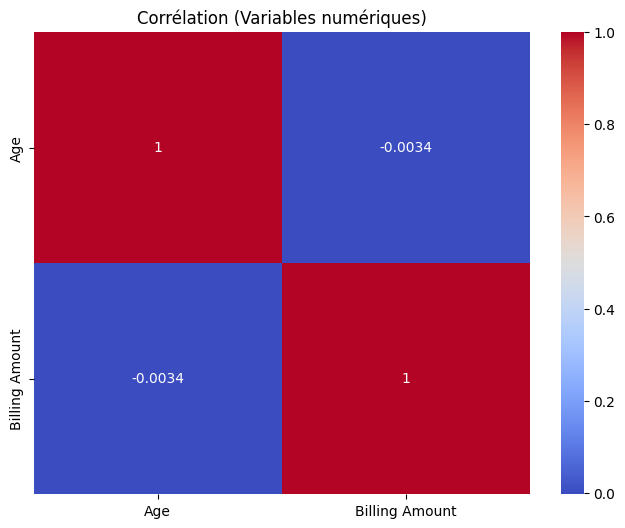

In [7]:
# Matrice de corrélation (sur les variables numériques uniquement pour l'instant)
plt.figure(figsize=(8,6))
sns.heatmap(data.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation (Variables numériques)")
plt.show()

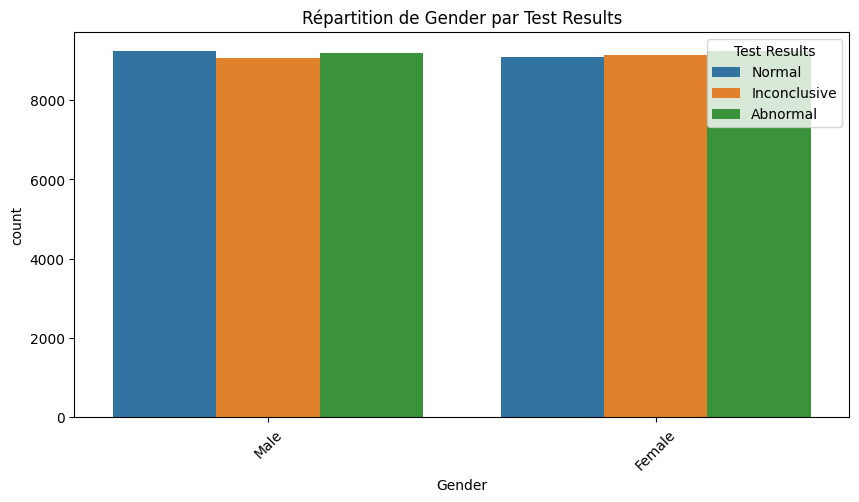

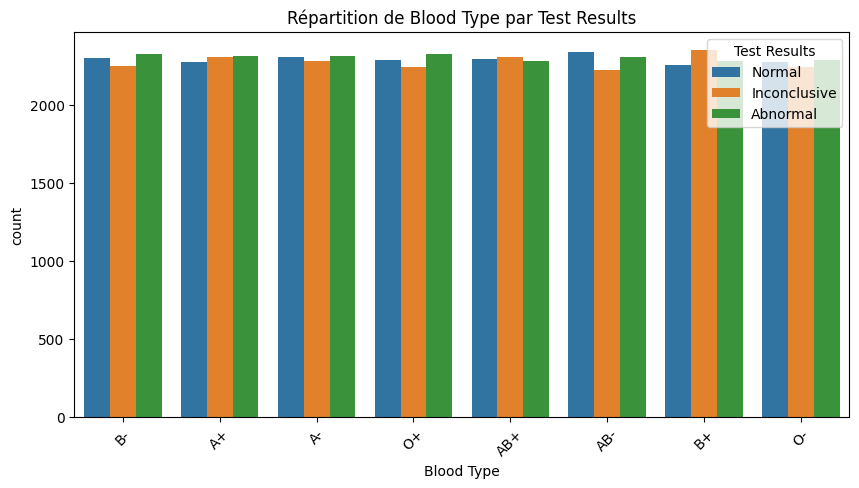

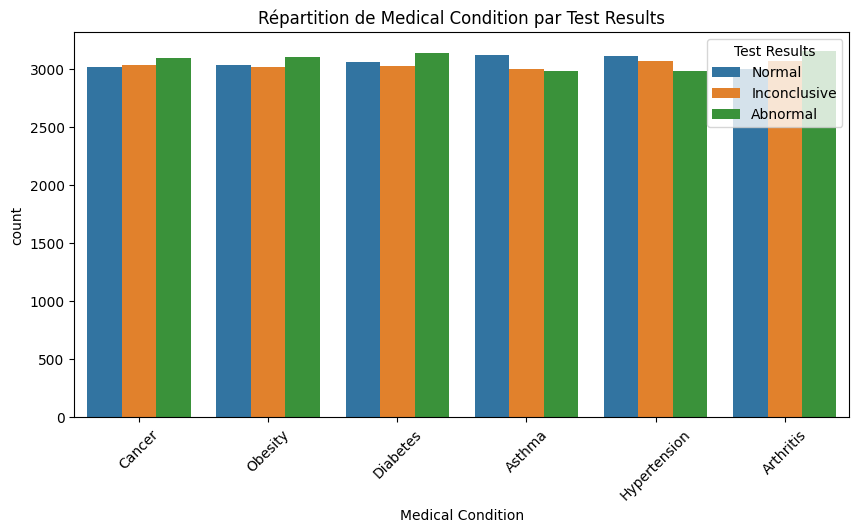

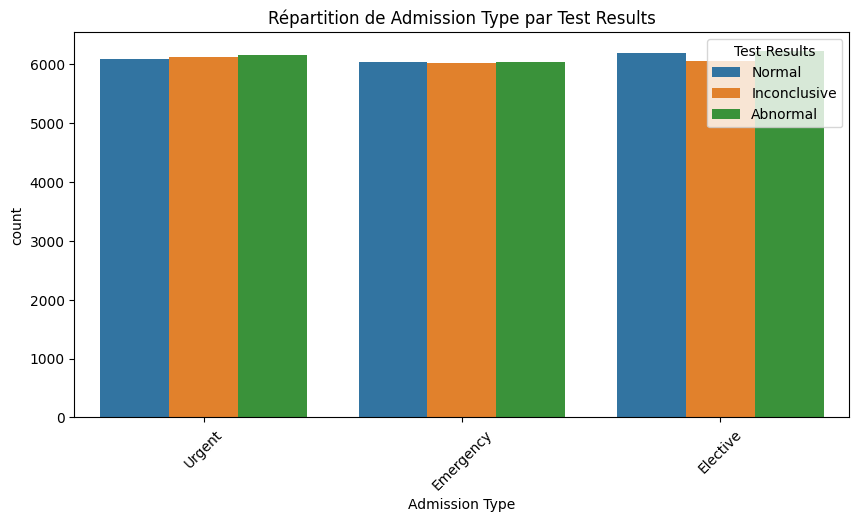

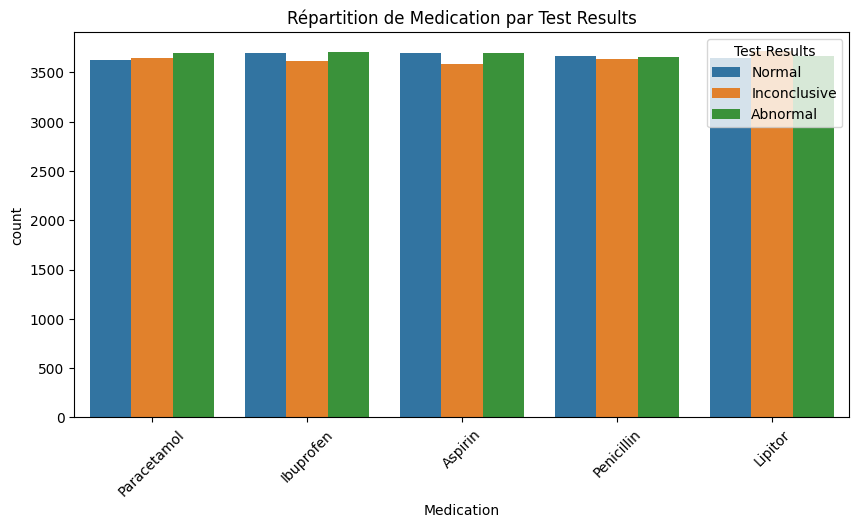

In [8]:
# Relation entre les variables catégorielles et l'état de santé
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Test Results')  # Exclure la cible
for col in categorical_cols:
    plt.figure(figsize=(10,5))
    sns.countplot(data=data, x=col, hue='Test Results')
    plt.title(f"Répartition de {col} par Test Results")
    plt.xticks(rotation=45)
    plt.show()

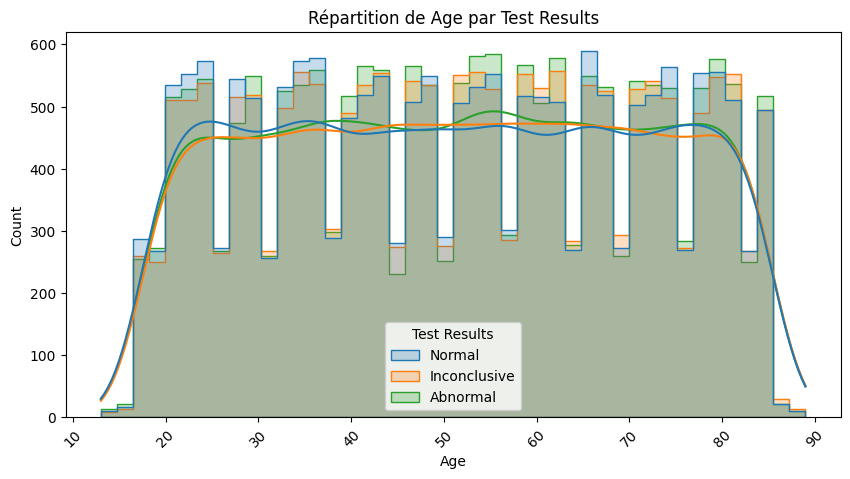

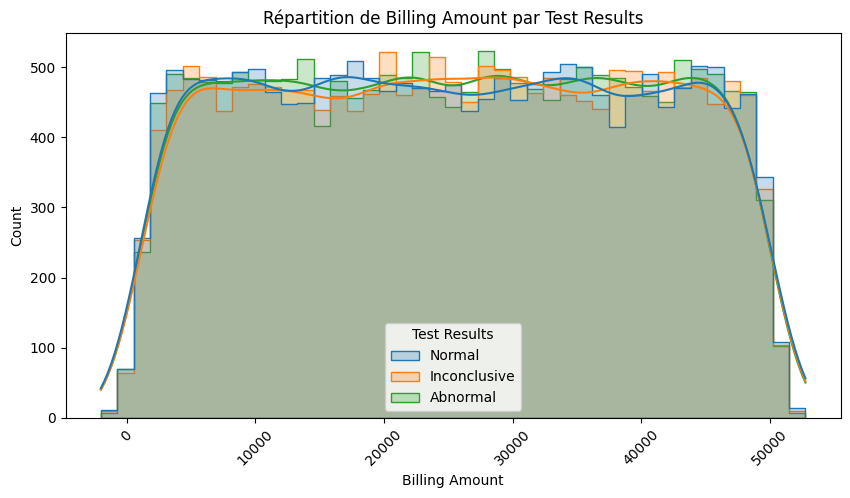

In [9]:
# Relation entre les variables numériques et l'état de santé
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
for col in numerical_cols:
    plt.figure(figsize=(10,5))
    sns.histplot(data=data, x=col, hue='Test Results', kde=True, element="step")
    plt.title(f"Répartition de {col} par Test Results")
    plt.xticks(rotation=45)
    plt.show()

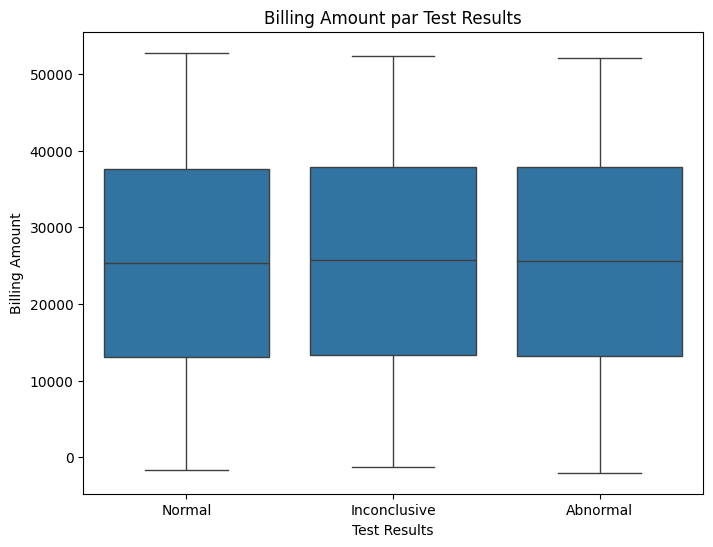

In [10]:
# Vérifions la corrélation entre billing et test results
plt.figure(figsize=(8,6))
sns.boxplot(data=data, x='Test Results', y='Billing Amount')
plt.title("Billing Amount par Test Results")
plt.show()

In [11]:
# Différentes valeurs catégorielles
for col in categorical_cols:
    print(f"\nValeurs uniques dans {col} : {data[col].unique()}")


Valeurs uniques dans Gender : ['Male' 'Female']

Valeurs uniques dans Blood Type : ['B-' 'A+' 'A-' 'O+' 'AB+' 'AB-' 'B+' 'O-']

Valeurs uniques dans Medical Condition : ['Cancer' 'Obesity' 'Diabetes' 'Asthma' 'Hypertension' 'Arthritis']

Valeurs uniques dans Admission Type : ['Urgent' 'Emergency' 'Elective']

Valeurs uniques dans Medication : ['Paracetamol' 'Ibuprofen' 'Aspirin' 'Penicillin' 'Lipitor']


In [12]:
# Pourcentage de la distribution de toutes les variables catégorielles sans visualisation
for col in categorical_cols:
    print(f"\nDistribution de {col} :")
    print(data[col].value_counts(normalize=True) * 100)


Distribution de Gender :
Gender
Male      50.023651
Female    49.976349
Name: proportion, dtype: float64

Distribution de Blood Type :
Blood Type
A-     12.549576
A+     12.545937
B+     12.525925
AB+    12.520467
AB-    12.505913
B-     12.502274
O+     12.471346
O-     12.378561
Name: proportion, dtype: float64

Distribution de Medical Condition :
Medical Condition
Arthritis       16.770367
Diabetes        16.766729
Hypertension    16.648474
Obesity         16.639377
Cancer          16.628461
Asthma          16.546592
Name: proportion, dtype: float64

Distribution de Admission Type :
Admission Type
Elective     33.608049
Urgent       33.458865
Emergency    32.933086
Name: proportion, dtype: float64

Distribution de Medication :
Medication
Lipitor        20.081505
Ibuprofen      20.054215
Aspirin        19.983262
Paracetamol    19.948696
Penicillin     19.932322
Name: proportion, dtype: float64


In [13]:
# Pourcentage de la distribution de toutes les variables numériques sans visualisation
for col in numerical_cols:
    print(f"\nDistribution de {col} :")
    print(data[col].value_counts(normalize=True) * 100)


Distribution de Age :
Age
38    1.619183
57    1.602809
37    1.600990
34    1.560965
80    1.555507
        ...   
88    0.045483
16    0.043663
14    0.032748
13    0.025470
89    0.014554
Name: proportion, Length: 77, dtype: float64

Distribution de Billing Amount :
Billing Amount
39297.224989    0.003639
11726.626932    0.003639
48718.059112    0.003639
22459.041465    0.003639
44211.480634    0.003639
                  ...   
24747.348916    0.001819
40657.582493    0.001819
8441.147064     0.001819
34934.284113    0.001819
33207.706634    0.001819
Name: proportion, Length: 50000, dtype: float64


# =============================================================================
# 3. PREPROCESSING AVANCÉ (ONE-HOT ENCODING) -> C'est ici que ça change tout !
# =============================================================================

In [14]:
# 1. Encodage One-Hot (get_dummies)
# Cela va créer des colonnes comme 'Gender_Female', 'Gender_Male', etc.
X = pd.get_dummies(data.drop('Test Results', axis=1))

# Pour la cible (y), le LabelEncoder est correct car c'est la variable à prédire
le = LabelEncoder()
y = le.fit_transform(data['Test Results'])

# 2. SAUVEGARDE CRUCIALE DES COLONNES
# On doit mémoriser l'ordre exact et le nom des colonnes créées
model_columns = list(X.columns)

# 3. Split et Standardisation (Classique)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Entraînement
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_scaled, y_train)

,n_neighbors,9
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [15]:
# 2. Séparation X et y
X = data.drop('Test Results', axis=1)
y = data['Test Results']

In [16]:
# 3. Encodage manuel des variables catégorielles

# Tes dictionnaires (les mêmes que dans l'app)
mappings = {
    'Gender': {'Female': 0, 'Male': 1}, 
    'Blood Type': {'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7},
    'Medical Condition': {'Arthritis': 0, 'Asthma': 1, 'Cancer': 2, 'Diabetes': 3, 'Hypertension': 4, 'Obesity': 5},
    'Admission Type': {'Elective': 0, 'Emergency': 1, 'Urgent': 2},
    'Medication': {'Aspirin': 0, 'Ibuprofen': 1, 'Lipitor': 2, 'Paracetamol': 3, 'Penicillin': 4},
    'Test Results': {'Abnormal': 0, 'Inconclusive': 1, 'Normal': 2}
}

# On applique le remplacement colonne par colonne
# (Assure-toi que ton DataFrame s'appelle bien 'df' ou change le nom)
for col, mapping in mappings.items():
    if col in data.columns:
        data[col] = data[col].map(mapping)
        # Sécurité : si des valeurs ne sont pas dans le dictionnaire, on met -1 ou on gère
        data[col] = data[col].fillna(-1).astype(int) 

print("✅ Encodage en chiffres terminé ! Plus de colonnes '_A+', '_Urgent' etc.")
display(data.head()) # Tu devrais voir des chiffres partout, et PAS de nouvelles colonnes

✅ Encodage en chiffres terminé ! Plus de colonnes '_A+', '_Urgent' etc.


,Age,Gender,Blood Type,Medical Condition,Billing Amount,Admission Type,Medication,Test Results
0,30,1,5,2,18856.281306,2,3,2
1,62,1,0,5,33643.327287,1,1,1
2,76,0,1,5,27955.096079,1,0,2
3,28,0,6,3,37909.782410,0,1,0
4,43,0,2,2,14238.317814,2,4,0


In [17]:
# 3. One-Hot Encoding sur les variables catégorielles (Gender, Blood Type, etc.)
# pandas va automatiquement détecter les colonnes de texte et créer les colonnes binaires (ex: Blood Type_A+, Blood Type_B-...)
X = pd.get_dummies(X, drop_first=False)

In [18]:
# 4. Scaling (Mise à l'échelle 0-1)
# C'est CRUCIAL : L'Age (ex: 80) et Billing (ex: 5000) doivent être ramenés entre 0 et 1 comme les colonnes One-Hot
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# 5. Encodage de la cible (y)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [20]:
# 6. Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

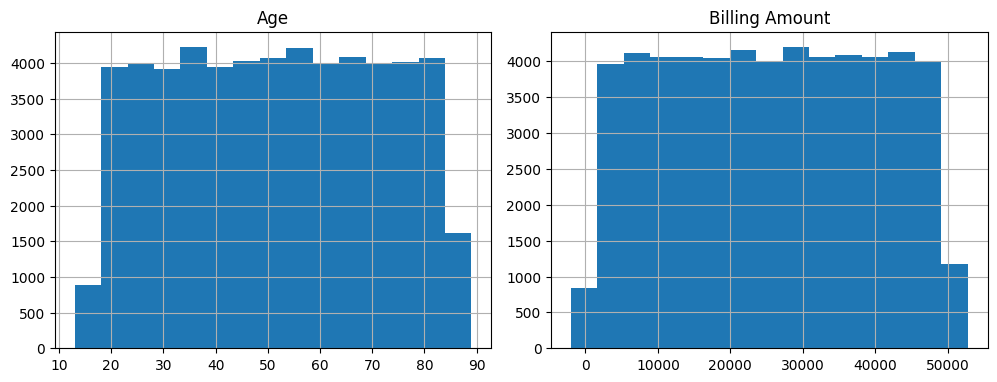

In [21]:
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols].hist(bins=15, figsize=(20, 25), layout=(7, 4))
plt.tight_layout()
plt.show()

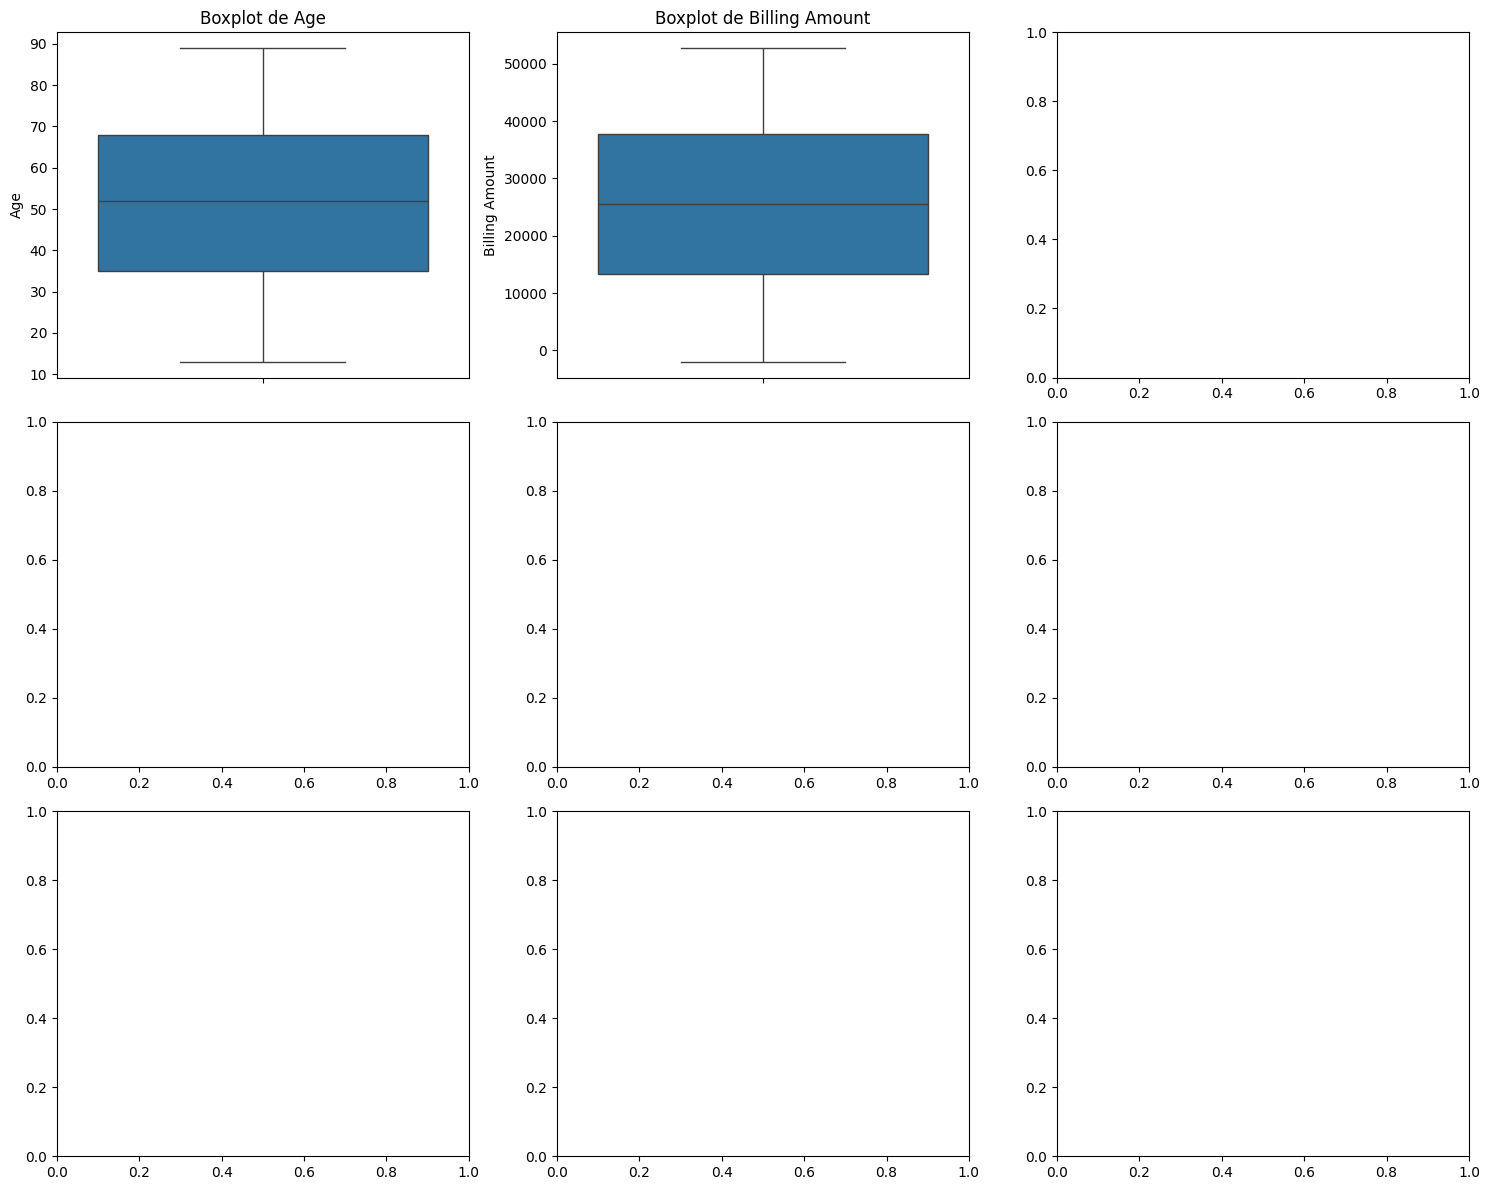

In [22]:
numeric_cols_for_outliers = X.select_dtypes(include=[np.number]).columns.tolist()
# Exclure les colonnes binaires (0/1)
binary_cols = [col for col in numeric_cols_for_outliers if X[col].nunique() <= 2]
cols_to_check = [col for col in numeric_cols_for_outliers if col not in binary_cols]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cols_to_check[:4]):  # Limiter à 8 pour la visualisation
    sns.boxplot(data=X, y=col, ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

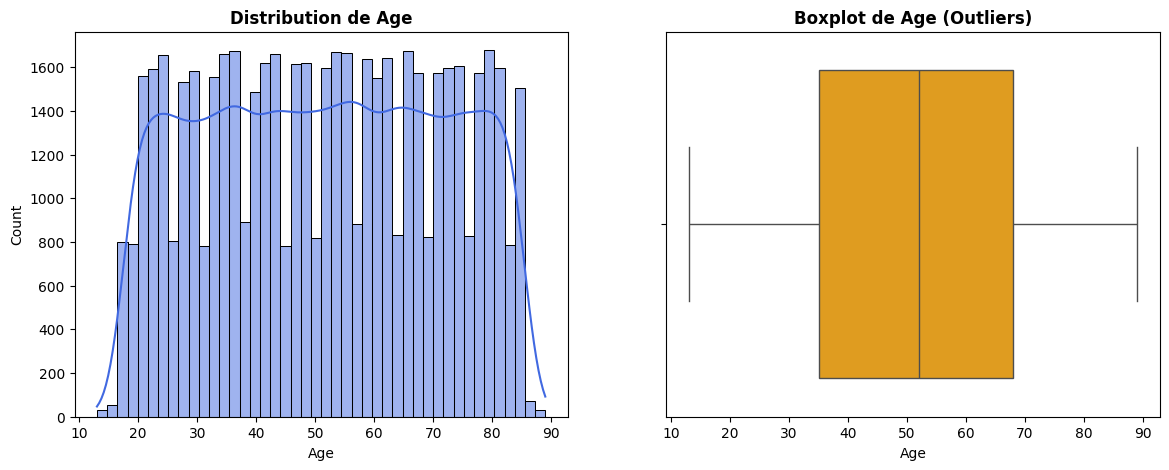

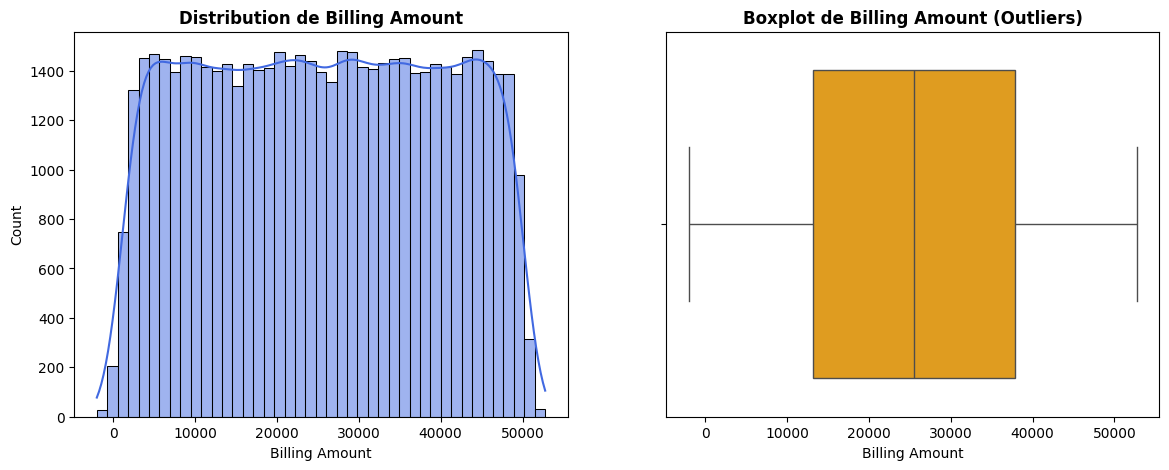

In [23]:
# Analyse des valeurs numériques
# Liste des variables numériques importantes
num_cols = ['Age', 'Billing Amount']

# On boucle sur chaque variable
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Histogramme + KDE (Densité)
    sns.histplot(X[col], kde=True, ax=axes[0], color='royalblue')
    axes[0].set_title(f'Distribution de {col}', fontweight='bold')
    
    # 2. Boxplot (Détection d\'Outliers)
    sns.boxplot(x=X[col], ax=axes[1], color='orange')
    axes[1].set_title(f'Boxplot de {col} (Outliers)', fontweight='bold')
    
    plt.show()

# =============================================================================
# 4. SPLIT ET SCALING
# =============================================================================

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X,           # Vos features (avec dummies)
    y_encoded,   # <--- UTILISER LA VERSION CHIFFRÉE ICI (PAS LE TEXTE)
    test_size=0.25, 
    random_state=42, 
    stratify=y_encoded
)

In [25]:
# Standardisation (Mettre l'Age et le Montant à la même échelle)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [26]:
# Initialisation du KNN avec distance Manhattan
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
knn.fit(X_train, y_train)

# Prédiction
y_pred = knn.predict(X_test)

# Évaluation
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    Abnormal       0.36      0.49      0.41      4609
Inconclusive       0.36      0.36      0.36      4550
      Normal       0.38      0.25      0.30      4583

    accuracy                           0.36     13742
   macro avg       0.37      0.36      0.36     13742
weighted avg       0.37      0.36      0.36     13742




# =============================================================================
# 5. OPTIMISATION DU MODÈLE (Recherche du meilleur K)
# =============================================================================

In [27]:

print("\n🔍 Recherche AVANCÉE de la meilleure configuration KNN...")

# On définit une grille plus intelligente
param_grid = {
    # On va de 1 à 31 par pas de 2 (1, 3, 5...) pour éviter les égalités
    'n_neighbors': range(1, 32, 2),       
    
    # 'distance' est souvent meilleur sur les données bruitées
    'weights': ['uniform', 'distance'], 
    
    # On enlève Hamming qui gère mal les floats (Age/Billing)
    # On garde Manhattan (souvent top pour OHE) et Euclidean (classique)
    'metric': ['manhattan', 'euclidean'] 
}

# Configuration du GridSearch
grid_search = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1, # Utilise toute la puissance processeur
    verbose=1  # Affiche la progression
)

grid_search.fit(X_train, y_train)

# Récupération des meilleurs résultats
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\n✅ Meilleure configuration trouvée :")
print(f"   - Nombre de voisins (K) : {best_params['n_neighbors']}")
print(f"   - Type de pondération   : {best_params['weights']}")
print(f"   - Métrique de distance  : {best_params['metric']}")
print(f"✅ Meilleur Score (Train CV) : {grid_search.best_score_:.4f}")

# Test final pour voir si on a battu les 36%
print("\n--- Test Final sur les données inconnues ---")
print(classification_report(y_test, best_model.predict(X_test), target_names=le.classes_))



🔍 Recherche AVANCÉE de la meilleure configuration KNN...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

✅ Meilleure configuration trouvée :
   - Nombre de voisins (K) : 3
   - Type de pondération   : distance
   - Métrique de distance  : manhattan
✅ Meilleur Score (Train CV) : 0.3960

--- Test Final sur les données inconnues ---
              precision    recall  f1-score   support

    Abnormal       0.41      0.41      0.41      4609
Inconclusive       0.40      0.40      0.40      4550
      Normal       0.41      0.41      0.41      4583

    accuracy                           0.41     13742
   macro avg       0.41      0.41      0.41     13742
weighted avg       0.41      0.41      0.41     13742



# =============================================================================
# 6. ÉVALUATION FINALE
# =============================================================================


--- RAPPORT FINAL SUR LE TEST SET ---
              precision    recall  f1-score   support

    Abnormal       0.41      0.41      0.41      4609
Inconclusive       0.40      0.40      0.40      4550
      Normal       0.41      0.41      0.41      4583

    accuracy                           0.41     13742
   macro avg       0.41      0.41      0.41     13742
weighted avg       0.41      0.41      0.41     13742



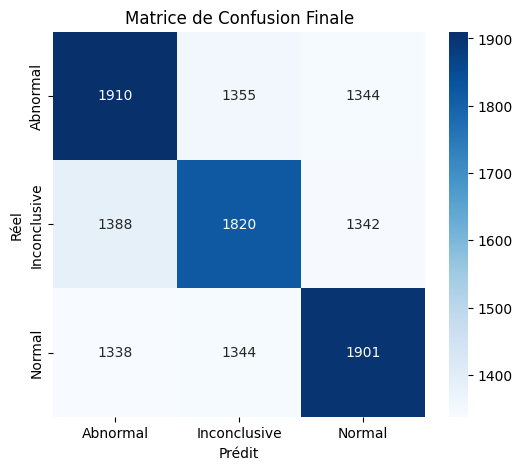

In [28]:
y_pred = best_model.predict(X_test)

print("\n--- RAPPORT FINAL SUR LE TEST SET ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matrice de confusion
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de Confusion Finale')
plt.ylabel('Réel')
plt.xlabel('Prédit')
plt.show()

# =============================================================================
# 7. SAUVEGARDE POUR STREAMLIT
# =============================================================================

In [29]:
# --- CELLULE DE SAUVEGARDE À EXÉCUTER DANS LE NOTEBOOK ---
import pickle
import pandas as pd

# 1. On s'assure d'avoir la liste des colonnes
# (Si X a été créé avec get_dummies plus haut, X.columns contient les noms comme 'Gender_Male', etc.)
model_columns = list(X.columns) 

# 2. On prépare les données à sauvegarder
# ATTENTION : On ajoute bien 'model_columns' ici
data_to_save = {
    "model": knn,
    "scaler": sc,
    "model_columns": list(X.columns), # Sauvegarde des noms de colonnes dummies
    "target_mapping": dict(zip(le.classes_, range(len(le.classes_)))) # Pour traduire 0->Abnormal
}

# 3. On écrase le fichier existant
with open('model_knn.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

print("✅ Fichier model_knn.pkl mis à jour avec succès ! Contient 'model_columns'.")

✅ Fichier model_knn.pkl mis à jour avec succès ! Contient 'model_columns'.
